__title__:TextCNN

__author__:@lzy

__time__:2018.02.06

# code is far away from bugs with the god animal protecting
    I love animals. They taste delicious.
              ┏┓      ┏┓
            ┏┛┻━━━┛┻┓
            ┃      ☃      ┃
            ┃  ┳┛  ┗┳  ┃
            ┃      ┻      ┃
            ┗━┓      ┏━┛
                ┃      ┗━━━┓
                ┃  神兽保佑    ┣┓
                ┃　永无BUG！   ┏┛
                ┗┓┓┏━┳┓┏┛
                  ┃┫┫  ┃┫┫
                  ┗┻┛  ┗┻┛


In [3]:
#coding: utf-8
import tensorflow as tf
import warnings
import numpy as np

if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/root/.pyenv/versions/anaconda3-5.0.0/envs/envAnaconda500/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: No GPU found. Please use a GPU to train your neural network.
  import sys


In [1]:
w2v_cropus_file = './corpus/corpus_text8.txt'

def loadword2vec(filename):
    '''
    @param w2v_file: w2v file path
    @return word2vec_dict: a dictionary includes word and corresponding vector{word:vector}
    @return word_dim: dimension of word
    '''
    vocab = []
    embed = []
    fr = open(filename,'r')
    line = fr.readline().strip()
    
    word_dim = int(line.split(' ')[1])
    vocab.append('UNK')
    embed.append([0]*word_dim)
    
    for line in fr:
        row = line.strip().split(' ')
        vocab.append(row[0])
        embed.append(row[1:])
    
    print('load w2v over')
    fr.close()
    return vocab,embed

#########define test###########################
vocab,embed = loadword2vec(w2v_cropus_file)
vocab_size = len(vocab)
embedding_dim = len(embed[0])

print(embedding_dim)
print(vocab_size) 
print(vocab[0:100])

load w2v over
200
47135
['UNK', 'the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was', 'by', 'that', 'four', 'six', 'seven', 'with', 'on', 'are', 'it', 'from', 'or', 'his', 'an', 'be', 'this', 'which', 'at', 'he', 'also', 'not', 'have', 'were', 'has', 'but', 'other', 'their', 'its', 'first', 'they', 'some', 'had', 'all', 'more', 'most', 'can', 'been', 'such', 'many', 'who', 'new', 'used', 'there', 'after', 'when', 'into', 'american', 'time', 'these', 'only', 'see', 'may', 'than', 'world', 'i', 'b', 'would', 'd', 'no', 'however', 'between', 'about', 'over', 'years', 'states', 'people', 'war', 'during', 'united', 'known', 'if', 'called', 'use', 'th', 'system', 'often', 'state', 'so', 'history', 'will', 'up', 'while']


In [5]:
def get_init_embed(vocab_size,embedding_dim):
    '''
    @param vocab_size: Number of words in vocabulary
    @param embedding_dim: Number of embedding dimensions
    @return embedding weight
    '''
    embed = tf.Variable(tf.random_uniform((vocab_size,embed_dim),-1,1),name='embedding')     
    return embed
    
def get_pretraind_embed(sess,w2v_file=None):
    '''
    @param sess: tf session
    @param index2word: Word2index vocabulary for input text
    @param vocab_size: Number of words of pretained materials
    @param embedding_dim: Number of embedding dimensions
    @param w2v_file: w2v file path
    
    '''

    embedding_init = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_dim]),
                                 trainable=False, name="embedding")

    print("using pre-trained word embedding")
    vocab,embed = loadword2vec(w2v_cropus_file)
    vocab_size = len(vocab)
    embedding_dim = len(embed[0])
    embeding = np.asarray(embed)
    
    embedding_placeholder = tf.placeholder(tf.float32,[vocab_size,embedding_dim])
    
    #assign the value to embedding weight
    tf_assign_embedding = tf.assign(embedding_placeholder)
            
    sess.run(tf_assign_embedding,feed_dict={embedding_placeholder: embedding});

 模型网络结构图
 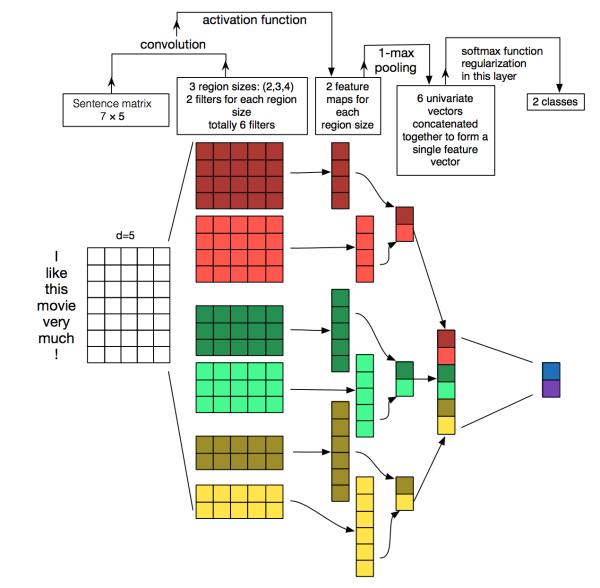
 filter_size(2,3,4),每种长度filter包含两层

In [6]:
def conv2d_maxpooling(x_tensor,conv_num_outputs,conv_ksize, conv_strides, pool_ksize, pool_strides):
    
    """
    @param x_tensor: TensorFlow Tensor
    @param conv_num_outputs: Number of outputs for the convolutional layer
    @param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    @param conv_strides: Stride 2-D Tuple for convolution
    @param pool_ksize: kernal size 2-D Tuple for pool
    @param pool_strides: Stride 2-D Tuple for pool
    @return: A tensor that represents convolution and max pooling of x_tensor
    """
    #shape=[height,width,Depth,num]
    segment_filter = tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],1,conv_num_outputs],stddev=0.1))
    bias = tf.Variable(tf.random_normal([conv_num_outputs],-1/np.sqrt(conv_num_outputs),1/np.sqrt(conv_num_outputs)))
    
    #convolution_weight
    conv_layer = tf.nn.conv2d(x_tensor,segment_filter,strides=[1,conv_strides[0],conv_strides[1],1],padding='SAME',name='conv')
    
    #convlution_bias
    conv_layer = tf.nn.bias_add(conv_layer,bias)
    
    #activation:relu
    conv_layer = tf.nn.relu(conv_layer)
    
    #max_pooling
    pooling_layer = tf.nn.max_pool(conv_layer,
                                   ksize = [1,pool_ksize[0],pool_ksize[1],1], #shape= [batch, height, width, channels]
                                   strides=[1,pool_strides[0],pool_strides[1],1],
                                   padding='SAME',
                                   name='pool')      
    
    return pooling_layer



def regularization(x_tensor,keep_prob):
    '''
    droup out regularization
    @param x_tensor: TensorFlow Tensor
    @param keep_prob: cell drop keep probability
    @return a tensor with dropout regularization strategy
    '''
    dropout_layer = tf.nn.dropout(x_tensor,keep_prob=keep_prob)
    

def flatten(x_tensor):
    flatten_layer =  tf.contrib.layers.flatten(x_tensor)
    return flatten


def output(x_tensor,num_class):
    '''
    @param input_shape: TensorFlow Tensor,second dimension is former layer result
    @param num_class: num of classication class
    @return 2-D tensor, second dimension is output result
    '''
    num_filters_total = x_tensor[1]
    weights = tf.Variable(tf.truncated_normal([num_filters_total, num_class],stddev=0.1))
    bias = tf.Variable(tf.random_uniform([num_class],-1/np.sqrt(num_class),1/np.sqrt(num_class)))
    
    output_layer = tf.add(tf.matmul(x_tensor,weights),bias)
    return output_layer

    创建卷积模型

In [7]:
def conv_net(w2v_input,embed_size,filter_size_tuple,filter_num,max_sequence_length,keep_prob,num_class):
    '''
    @param w2v_input:word2vector input 
    @param embed_size: word embedding size,here is 200
    @param filter_size_tuple: a tuple with different filter size, here is (2,3,4)
    @param filter_num: num of filter for each filter size,here is 2
    @param max_sequence_length: max sequence length allowed
    @param keep_prob: cell drop keep probability
    @param num_class: num of classification (2 or mulitple)
    @return logits tensor
    '''
        
    pooling_list = []
    for i,filter_size in enumerate(filter_size_tuple):
        with tf.name_scope('convolution-pooling-{0}'.format(filter_size)):
            conv_pooling = conv2d_maxpooling(x_tensor=w2v_input,
                                             conv_num_outputs = filter_num,
                                             conv_ksize = (filter_size,embed_size),
                                             conv_strides = (1,1),
                                             pool_ksize= (max_sequence_length-filter_size+1,1),   #full matrix max_pooling
                                             pool_strides =(1,1) 
                                            )
        
            pooling_list.append(conv_pooling)
    
    concat_pooling = tf.concat(pooling_list,3) #concat num_filters_total(3*2)
    
    with tf.name_scope('flatten'):
        pool_flatten_layer = flatten(concat_pooling)
    
    with tf.name_scope('dropout'):
        dropout_layer = regularization(pool_flatten_layer,keep_prob)
        
    with tf.name_scope('full_connect'):
        logits = output(dropout_layer,num_class)
    
    return logits
    

    数据预处理（文本转词向量）

In [8]:
from tensorflow.contrib import learn

def preprocessing(vocab_input,vocab,max_sentence_length,pretrained = True):
    '''
    @param vocab_input: original vocabulary 
    @param embed_size: word embedding size,here is 200
    @return word2index table
    '''
    word2index_input=[]
    if pretrained:
        vocab_processor = learn.preprocessing.VocabularyProcessor(max_sentence_length)
        #fit the pretrained vocab  
        pretrain = vocab_processor.fit(vocab)
        
        for v in vocab_input:
            word2index_sentence = np.array(list(vocab_processor.transform(v)))
            word2index_input.append(word2index_sentence)
            
    else:
        assert 1 == 0,'function still under developing'
        
        
    return word2index_input


    变量定义

In [9]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset = 'train')
newsgroups_text = fetch_20newsgroups(subset = 'test')
newsgroups_all = fetch_20newsgroups(subset = 'train')

from pprint import pprint
pprint(list(newsgroups_train.target_names))

print('texts item in train: %d'%(len(newsgroups_train.data)))
print('texts item in test: %d'%(len(newsgroups_text.data)))

print('text',newsgroups_text.data[0])

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
texts item in train: 11314
texts item in test: 7532
text From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)
Subject: Need info on 88-89 Bonneville
Organization: University at Buffalo
Lines: 10
News-Software: VAX/VMS VNEWS 1.41
Nntp-Posting-Host: ubvmsd.cc.buffalo.edu


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually

In [10]:
vocab,embed = loadword2vec(w2v_cropus_file)
vocab_size = len(vocab)
embedding_dim = len(embed[0])


print(embedding_dim)
print(vocab_size) 

load w2v over
200
47135


    分析句子长度，使用所有句子90%长度为max length

In [11]:
#max sentence length
len_counter = np.zeros(len(newsgroups_all.data))
for i,data in enumerate(newsgroups_all.data):
    len_counter[i] = len(data)

print(np.max(len_counter))
print(np.min(len_counter))
print(np.mean(len_counter))
print(np.median(len_counter))
print(np.percentile(len_counter,75))   


75154.0
125.0
1949.31005833
1178.0
1881.0


In [ ]:
word2index_train = []
print(vocab[0:5])
max_sentence_len = int(np.percentile(len_counter,30))
w2i = preprocessing(newsgroups_train.data,vocab,max_sentence_len)

print(w2i[1])

['UNK', 'the', 'of', 'and', 'one']


In [72]:
print(len(w2i))

6
